<a href="https://colab.research.google.com/github/GurionRamapoguSajeevan/GenAI-customer-review-sentiment-engine/blob/main/GenAI_sentiment_review_engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# STEP 1: LIBRARIES AND INITIAL SET UP

## Installing required Libraries

In [ ]:
!pip install pandas nltk spacy scikit-learn transformers matplotlib seaborn streamlit
!python -m spacy download en_core_web_sm  # For English NLP preprocessing

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 139.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


## Importing necessary libraries

In [ ]:
import pandas as pd
import nltk
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
nltk.download('punkt')
nltk.download('stopwords')
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# STEP 2: Loading and Understanding the Data

In [ ]:
df = pd.read_csv('/content/amazon_review.csv')

In [ ]:
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime,day_diff,helpful_yes,total_vote
0,A3SBTW3WS4IQSN,B007WTAJTO,NaN,"[0, 0]",No issues.,4,Four Stars,1406073600,7/23/2014,138,0,0
1,A18K1ODH1I2MVB,B007WTAJTO,0mie,"[0, 0]","Purchased this for my device, it worked as adv...",5,MOAR SPACE!!!,1382659200,10/25/2013,409,0,0
2,A2FII3I2MBMUIA,B007WTAJTO,1K3,"[0, 0]",it works as expected. I should have sprung for...,4,nothing to really say....,1356220800,12/23/2012,715,0,0
3,A3H99DFEG68SR,B007WTAJTO,1m2,"[0, 0]",This think has worked out great.Had a diff. br...,5,Great buy at this price!!! *** UPDATE,1384992000,11/21/2013,382,0,0
4,A375ZM4U047O79,B007WTAJTO,2&amp;1/2Men,"[0, 0]","Bought it with Retail Packaging, arrived legit...",5,best deal around,1373673600,7/13/2013,513,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      4915 non-null   object
 1   asin            4915 non-null   object
 2   reviewerName    4914 non-null   object
 3   helpful         4915 non-null   object
 4   reviewText      4914 non-null   object
 5   overall         4915 non-null   int64 
 6   summary         4915 non-null   object
 7   unixReviewTime  4915 non-null   int64 
 8   reviewTime      4915 non-null   object
 9   day_diff        4915 non-null   int64 
 10  helpful_yes     4915 non-null   int64 
 11  total_vote      4915 non-null   int64 
dtypes: int64(5), object(7)
memory usage: 460.9+ KB


### Relevant columns: We'll focus on reviewText (for text analysis), overall (rating, as a proxy for sentiment validation), and asin (product ID, for filtering in the dashboard).

In [ ]:
df = df[['reviewText', 'overall', 'asin']]
df.head()

,reviewText,overall,asin
0,No issues.,4,B007WTAJTO
1,"Purchased this for my device, it worked as adv...",5,B007WTAJTO
2,it works as expected. I should have sprung for...,4,B007WTAJTO
3,This think has worked out great.Had a diff. br...,5,B007WTAJTO
4,"Bought it with Retail Packaging, arrived legit...",5,B007WTAJTO


# Step 3: Cleaning and Preprocessing the Text

In [ ]:
# Here I am defining a preprocessing function (this handles lowercase, tokenization, stopword removal, and lemmatization—standard NLP steps to make text ready for models):

### this extra one is needed for the tabular data in the tokenizer. 'punkt_tab' tokenizer model required for word_tokenize in recent NLTK versions

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

#### 1. First, drop any rows where the actual reviewText is missing


In [ ]:
df = df.dropna(subset=['reviewText'])

#### 2. Define Preprocessing for LDA (Topic Modeling) ONLY

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))

def preprocess_text_for_topics(text):
    if pd.isna(text):
        return ''
    text = text.lower()
    tokens = word_tokenize(text)
    # Remove stopwords and non-alphanumeric (CRITICAL: Only do this for Topic Modeling, not Sentiment!)
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    doc = nlp(' '.join(tokens))
    lemmatized = [token.lemma_ for token in doc]
    return ' '.join(lemmatized)


#### 3. Applying the Preprocessing Function to the reviewText column:

In [ ]:
df['cleaned_review'] = df['reviewText'].apply(preprocess_text_for_topics)

#### 4. Filtering out rows that became empty after cleaning (so LDA doesn't crash), but keeping the index aligned for the raw text.


In [ ]:
df = df[df['cleaned_review'].str.len() > 0].copy()

print("Data ready. 'reviewText' will be used for AI, 'cleaned_review' for LDA.")
df.head()

Data ready. 'reviewText' will be used for AI, 'cleaned_review' for LDA.


,reviewText,overall,asin,cleaned_review
0,No issues.,4,B007WTAJTO,issue
1,"Purchased this for my device, it worked as adv...",5,B007WTAJTO,purchase device work advertise never much phon...
2,it works as expected. I should have sprung for...,4,B007WTAJTO,work expect sprung high capacity think make bi...
3,This think has worked out great.Had a diff. br...,5,B007WTAJTO,think work diff bran 64 gb card go south 3 one...
4,"Bought it with Retail Packaging, arrived legit...",5,B007WTAJTO,buy retail packaging arrive legit orange envel...


# Step 4: Extract Insights Using NLP and AI Models

####  1. Sentiment Analysis (using a lightweight DistilBERT model)

In [ ]:

# NEW MODEL: Uses a 5-star rating system which we map to 3 classes (Neg/Neu/Pos).

sentiment_pipeline = pipeline(
    'sentiment-analysis',
    model='nlptown/bert-base-multilingual-uncased-sentiment',
    device=0
)

# a. Prepare raw text list
raw_reviews = df['reviewText'].astype(str).tolist()

# b. Run inference in batches
sentiment_results = sentiment_pipeline(raw_reviews, truncation=True, batch_size=16)

# c. Define the mapping function to convert 5-star to 3-class label
def map_star_to_sentiment(label):
    if label in ['1 star', '2 stars']:
        return 'NEGATIVE'
    elif label == '3 stars':
        return 'NEUTRAL'
    elif label in ['4 stars', '5 stars']:
        return 'POSITIVE'
    # Handle potential label formatting (e.g., 'X star' vs 'X stars')
    elif 'star' in label:
        star_num = int(label.split()[0])
        if star_num <= 2:
            return 'NEGATIVE'
        elif star_num == 3:
            return 'NEUTRAL'
        else:
            return 'POSITIVE'
    return 'NEUTRAL' # Default fallback

# d. Extract labels and apply mapping
df['sentiment'] = [map_star_to_sentiment(result['label']) for result in sentiment_results]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


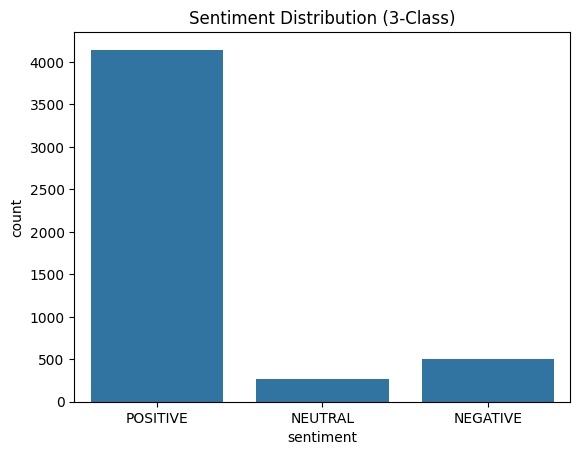

In [ ]:
# e. Vizualization check
sns.countplot(x='sentiment', data=df)
plt.title("Sentiment Distribution (3-Class)")
plt.show()

In [ ]:
# Checking a sample to verify "Positives" aren't hallucinating on negative words
print(df[['reviewText', 'sentiment']].head(10))

                                          reviewText sentiment
0                                         No issues.  POSITIVE
1  Purchased this for my device, it worked as adv...  POSITIVE
2  it works as expected. I should have sprung for...   NEUTRAL
3  This think has worked out great.Had a diff. br...  NEGATIVE
4  Bought it with Retail Packaging, arrived legit...  POSITIVE
5  It's mini storage.  It doesn't do anything els...   NEUTRAL
6  I have it in my phone and it never skips a bea...  POSITIVE
7  It's hard to believe how affordable digital ha...  POSITIVE
8  Works in a HTC Rezound.  Was running short of ...  POSITIVE
9  in my galaxy s4, super fast card, and am total...  POSITIVE


#### 2. Themes/Topics (using traditional LDA for simplicity and to show hybrid skills—AI + classic ML):

In [ ]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = vectorizer.fit_transform(df['cleaned_review'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # Extract 5 main themes
lda.fit(dtm)

# Display top words per theme (print in notebook)
for i, topic in enumerate(lda.components_):
    print(f"Theme {i}: {' '.join([vectorizer.get_feature_names_out()[index] for index in topic.argsort()[-10:]])}")

# Assign dominant theme to each review
df['theme'] = lda.transform(dtm).argmax(axis=1)

Theme 0: read 10 sandisk write class speed 32 64 gb card
Theme 1: month great product phone samsung buy galaxy sandisk card work
Theme 2: fast sandisk memory use price 34 buy sd good card
Theme 3: adapter memory price gopro video great camera use work card
Theme 4: memory tablet galaxy storage music great use work phone card


#### 3. Pain Points and Suggestions (using zero-shot classification with BART: another GPU-accelerated HuggingFace model, ):

In [ ]:
# Load Model
zero_shot_pipeline = pipeline(
    'zero-shot-classification',
    model='facebook/bart-large-mnli',
    device=0
)

pain_labels = ['quality issue', 'delivery problem', 'price complaint', 'usability issue', 'no pain']
suggestion_labels = ['improve durability', 'better packaging', 'add features', 'lower price', 'no suggestion']

# Prepare raw text list
raw_reviews = df['reviewText'].astype(str).tolist()

print("Processing Pain Points... (This may take a moment)")

# Batch process Pain Points
pain_results = zero_shot_pipeline(
    raw_reviews,
    candidate_labels=pain_labels,
    batch_size=8, # BART is larger, so we use a smaller batch size to avoid Out of Memory
    truncation=True
)
df['pain_point'] = [result['labels'][0] for result in pain_results]

print("Processing Suggestions...")
# Batch process Suggestions
suggestion_results = zero_shot_pipeline(
    raw_reviews,
    candidate_labels=suggestion_labels,
    batch_size=8,
    truncation=True
)
df['suggestion'] = [result['labels'][0] for result in suggestion_results]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0


Processing Pain Points... (This may take a moment)
Processing Suggestions...


# Step 5: Saving the Final Processed-reviewes Dataset

In [ ]:
# Save final
df.to_csv('/content/processed_reviews.csv', index=False)
print("Processing complete. File saved.")

Processing complete. File saved.
